# Magnetized Plasma in FDTD using ADE with Damping

## 1. Maxwell’s Equations in a Magnetized Plasma

The **current density** $\mathbf{J}$ in a plasma evolves dynamically under electric and magnetic fields.  

**Maxwell-Ampère equation:**

$$
\nabla \times \mathbf{H} = \epsilon_0 \frac{\partial \mathbf{E}}{\partial t} + \mathbf{J}
$$

**Electron motion under Lorentz force with damping:**

$$
m_e \frac{d\mathbf{v}}{dt} + m_e \nu \mathbf{v} = -e (\mathbf{E} + \mathbf{v} \times \mathbf{B}_0)
$$

- $\nu$ is the damping (collision) rate or stabilizing factor  
- $\mathbf{B}_0$ is the static magnetic field  
- $m_e$, $e$ are electron mass and charge  

Current density:

$$
\mathbf{J} = -e n_e \mathbf{v}
$$

---

## 2. ADE for a Damped Magnetized Plasma

Introducing the **Auxiliary Differential Equation** (ADE) for $\mathbf{J}$ with damping:

$$
\frac{d\mathbf{J}}{dt} + \nu \mathbf{J} + \mathbf{\Omega} \times \mathbf{J} = \epsilon_0 \omega_p^2 \mathbf{E}
$$

where:  

- $\mathbf{\Omega} = \omega_c \hat{\mathbf{B}}_0$ (cyclotron frequency vector)  
- $\omega_p$ is the plasma frequency  
- $\nu$ is the damping rate  

This **damping term** $\nu \mathbf{J}$ helps **stabilize the FDTD update** near resonances.

Maxwell’s equations become:

$$
\begin{aligned}
\epsilon_0 \frac{\partial \mathbf{E}}{\partial t} &= \nabla \times \mathbf{H} - \mathbf{J} \\
\mu_0 \frac{\partial \mathbf{H}}{\partial t} &= -\nabla \times \mathbf{E} \\
\frac{d\mathbf{J}}{dt} + \nu \mathbf{J} + \mathbf{\Omega} \times \mathbf{J} &= \epsilon_0 \omega_p^2 \mathbf{E}
\end{aligned}
$$

---

## 3. FDTD Update Scheme with Damping

At each time step:

1. **Update magnetic field**:

$$
\mathbf{H}^{n+1/2} = \mathbf{H}^{n-1/2} - \frac{\Delta t}{\mu_0} \nabla \times \mathbf{E}^n
$$

2. **Update plasma current** (explicit Euler):

$$
\mathbf{J}^{n+1} = \mathbf{J}^{n} + \Delta t \left( \epsilon_0 \omega_p^2 \mathbf{E}^n - \nu \mathbf{J}^{n} - \mathbf{\Omega} \times \mathbf{J}^{n} \right)
$$

> Optionally, we can use **semi-implicit or trapezoidal integration** for better stability.

3. **Update electric field**:

$$
\mathbf{E}^{n+1} = \mathbf{E}^n + \frac{\Delta t}{\epsilon_0} \left( \nabla \times \mathbf{H}^{n+1/2} - \mathbf{J}^{n+1} \right)
$$

> Damping ensures **numerical stability near plasma cutoffs and cyclotron resonances**.


## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from math import log as log
import fdtd
import fdtd.backend as bd
from fdtd.constants import m_e, q_e, eps0

## Set Backend

In [2]:
fdtd.set_backend("torch.cuda")

## Set Fonts

In [16]:
#to display inside the notebook!
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
mpl.rc('image', cmap='nipy_spectral')
%matplotlib inline
import matplotlib.font_manager as font_manager
from matplotlib.ticker import StrMethodFormatter
# print(font_manager.findSystemFonts(fontpaths=None, fontext='otf'))
font_dir = ['/home/pag/fonts/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
plt.rcParams['font.sans-serif'] = "Latin Modern Roman"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['mathtext.fontset'] = "stix"
# if fonts are missing install the latin family in the font directory (use function below to find the system directory)

scale=6
SMALL_SIZE = 3*scale
MEDIUM_SIZE = 4*scale
BIGGER_SIZE = 5*scale

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Constants

In [4]:
LIGHT_SPEED: float = 299_792_458.0  # [m/s] speed of light
SCALE = 1
DENSITY =1e20/2
MAGNETIC_FIELD:float = 4.5 * 0
FREQUENCY = 35e9
WAVELENGTH = LIGHT_SPEED / FREQUENCY
print(WAVELENGTH*1e3,' mm')

8.5654988  mm


## Simulation

create FDTD Grid

In [5]:
grid = fdtd.Grid(
    (.05, .5 , 1),
    grid_spacing=0.05 / (1.*SCALE) * WAVELENGTH,
    permittivity=1.0,
    permeability=1.0,
    courant_number = .1,
    plasma = True,
    use_p_e = True,
    frequency = FREQUENCY*0,
)


In [6]:
old_courant=grid.courant_number
dt=grid.time_step
n_e=bd.zeros(grid.E.shape)
B_T=bd.zeros(grid.E.shape)
B_T[:,:,:,0] = MAGNETIC_FIELD
for j in range(4*grid.Ny//5):
    n_e[:,j,0:1,:]=DENSITY*(1.-j*1./(4*grid.Ny//5-1))
for j in range(grid.Ny):
    B_T[:,j,0:1,0]=MAGNETIC_FIELD/(1+0.5*j*1./(grid.Ny-1))
grid.n_e += n_e    
grid.B_T = B_T

grid.update_J(); #this is to compute omega and OMEGA
print("Time step ",dt)
dt=min(dt,.01/(bd.max(grid.OMEGA**2).item()**.5/2./3.14+1e-9))
dt=min(dt,.1/(bd.max(grid.omega).item()/2./3.14+1e-9))
# grid.courant_number = 0.0079999999936
cfln = dt 
cfln /= grid.grid_spacing / LIGHT_SPEED
print("Courant Number ",grid.courant_number)
if (cfln != grid.courant_number):
    grid.courant_number=cfln
    grid.time_step = grid.courant_number * grid.grid_spacing / LIGHT_SPEED
print("New Time_step ",grid.time_step)
print("New Courant Number ",grid.courant_number)
grid.nu=bd.max(grid.omega).item()*1e-6
print('nu ',grid.nu)

Time step  1.4285714285714287e-13
Courant Number  0.1
New Time_step  1.4285714285714287e-13
New Courant Number  0.1
nu  398911.477454537


boundaries

In [7]:
# grid[0, :, :] = fdtd.PMLBoundary(name="xbounds")
grid[0:15*SCALE, :, :] = fdtd.PML(name="pml_xlow")
grid[-15*SCALE:, :, :] = fdtd.PML(name="pml_xhigh")

# grid[:, 0, :] = fdtd.PMLBoundary(name="ybounds")
grid[:, 0:15*SCALE, :] = fdtd.PML(name="pml_ylow")
grid[:, -15*SCALE:, :] = fdtd.PML(name="pml_yhigh")

grid[:, :, 0] = fdtd.PeriodicBoundary(name="zbounds")

sources

In [8]:
grid[int(-0.2*grid.Nx+grid.Nx/2):int(0.2*grid.Nx+grid.Nx/2)+1, int(.9*grid.Ny):int(.9*grid.Ny), 0] = fdtd.LineSource(
    period=1. / FREQUENCY, name="linesource"
)
# grid[100, 60, 0] = fdtd.PointSource(
#     period=WAVELENGTH / SPEED_LIGHT, name="pointsource",
# )

detectors

In [9]:
# grid[12e-6, :, 0] = fdtd.LineDetector(name="detector")

objects

## Run simulation

In [10]:
grid.run(1e-9, progress_bar=True)

100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:36<00:00, 192.77it/s]


## Visualization

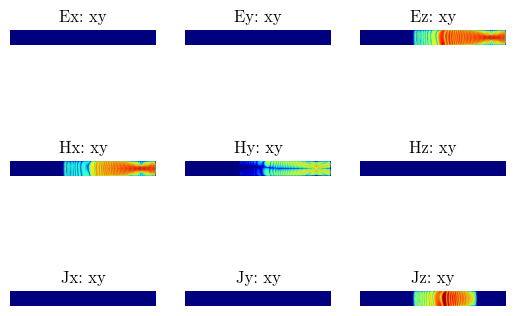

In [11]:
fig, axes = plt.subplots(3, 3, squeeze=False)
titles = ["Ex: xy", "Ey: xy", "Ez: xy", "Hx: xy", "Hy: xy", "Hz: xy", "Jx: xy", "Jy: xy", "Jz: xy"]
log_bias=1e-8
fields = bd.stack(
    [
        bd.log(grid.E[:, :, 0, 0]**2+log_bias)/2./log(10.),
        bd.log(grid.E[:, :, 0, 1]**2+log_bias)/2./log(10.),
        bd.log(grid.E[:, :, 0, 2]**2+log_bias)/2./log(10.),
        bd.log(grid.H[:, :, 0, 0]**2+log_bias)/2./log(10.),
        bd.log(grid.H[:, :, 0, 1]**2+log_bias)/2./log(10.),
        bd.log(grid.H[:, :, 0, 2]**2+log_bias)/2./log(10.),
        bd.log(grid.J[:, :, 0, 0]**2+log_bias)/2./log(10.),
        bd.log(grid.J[:, :, 0, 1]**2+log_bias)/2./log(10.),
        bd.log(grid.J[:, :, 0, 2]**2+log_bias)/2./log(10.),
    ]
)

mini = fields.min().item()
maxi = fields.max().item()

for ax, field, title in zip(axes.ravel(), fields, titles):
    ax.set_axis_off()
    ax.set_title(title)
    ax.imshow(bd.numpy(field), vmin=mini, vmax=maxi, cmap="jet")

plt.savefig("array.png", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=0)

plt.show()

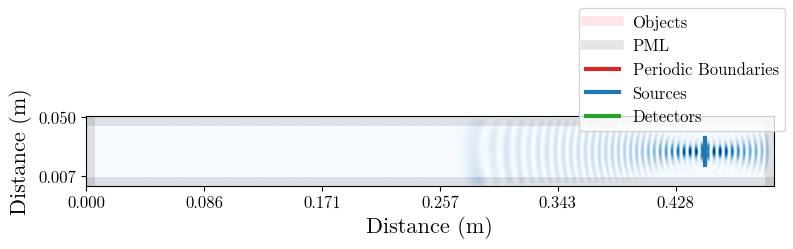

In [12]:
grid.visualize(cmap="Blues",z=0,index=1,scale=1,save=True,folder="./")

In [13]:
E_xy=(grid.E[:, :, 0, 0]**2+grid.E[:, :, 0, 1]**2)**0.5
E_z=(grid.E[:, :, 0, 2]**2)**0.5
E_norm=(grid.E[:, :, 0, 0]**2+grid.E[:, :, 0, 1]**2+grid.E[:, :, 0, 2]**2)**0.5
J_norm=(grid.J[:, :, 0, 0]**2+grid.J[:, :, 0, 1]**2+grid.J[:, :, 0, 2]**2)**0.5
E_r=E_z/(E_xy+1e-4)

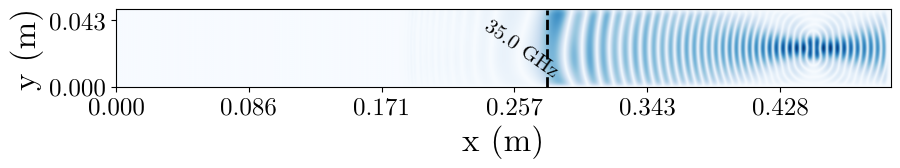

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot your electric field
im = ax.imshow(bd.numpy(E_norm)/bd.max(E_norm).item(), cmap=plt.cm.Blues, origin='lower')
im.set_interpolation('bicubic')

# Overlay equi-cutoff contour(s)
f_target = FREQUENCY  # example cutoff frequency (change this)
cutoffs_np = bd.numpy(grid.omega[:,:,0,0]/2./3.1416)  # convert to numpy if needed

# Draw contour where cutoff = f_target
CS = ax.contour(
    cutoffs_np, 
    levels=[f_target], 
    colors='black',     # color of contour
    linewidths=2, 
    linestyles='--'
)
# Optional: label the contour with its frequency
ax.clabel(
    CS,
    inline=True,
    fontsize=15,
    fmt=lambda x: f"{x/1e9:.1f} GHz         ",
    manual=[(30, 30)],   # optional: manually place label
    rightside_up=True
)
for txt in CS.labelTexts:
    txt.set_rotation(-35)  # rotate 45 degrees

ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f"{val*grid.grid_spacing:.3f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f"{val*grid.grid_spacing:.3f}"))

# Add colorbar and labels
# cb = fig.colorbar(im, orientation='horizontal', location ='top')
# cb.ax.set_ylabel('E (A.U.)', rotation=0)
# cb.ax.yaxis.set_label_coords(.5, -.8)
plt.xlabel('x (m)', rotation=0)
plt.ylabel('y (m)', rotation=90)
plt.savefig("E.png", 
               bbox_inches='tight', 
               transparent=False,
               pad_inches=.1)
plt.show()

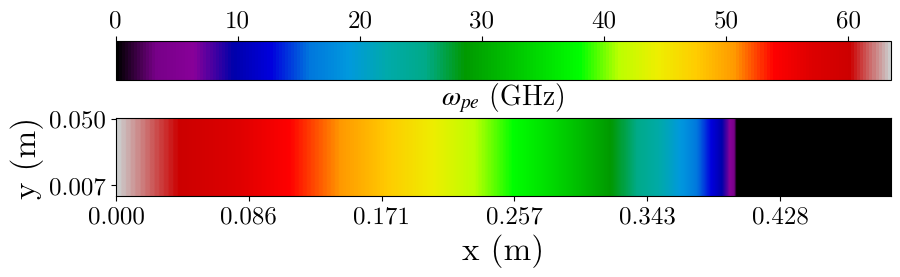

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))

# im = plt.imshow(bd.numpy(grid.OMEGA[:,:,:,0]), cmap=plt.cm.nipy_spectral)
im = plt.imshow(bd.numpy(grid.omega[:,:,0,0]/2./3.1416*1e-9), cmap=plt.cm.nipy_spectral)
# im = plt.imshow(bd.numpy(permittivity[:,:,0,0]), cmap=plt.cm.nipy_spectral)
im.set_interpolation('bicubic')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f"{val*grid.grid_spacing:.3f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f"{(grid.Nx-val)*grid.grid_spacing:.3f}"))

cb = fig.colorbar(im, orientation='horizontal', location ='top')
plt.xlabel('x (m)', rotation=0)
plt.ylabel('y (m)', rotation=90)
cb.ax.set_ylabel('$\\omega_{pe}$ (GHz)', rotation=0, size=20)
cb.ax.yaxis.set_label_coords(.5, -.9)
# plt.title('$\\omega_{pe}$ (GHz)',size=20)
plt.savefig("omega_pe.png", 
               bbox_inches='tight', 
               transparent=False,
               pad_inches=.1)
plt.show()